# Local Object Detection Training - Barcodes

This notebook trains a model to detect handwritten barcodes, starting and ending symbols as well as bars. It also extracts the bars and saves them in a separate folder (rotated in a way that the bar can be read from top to bottom). 


## Hardware

* GeForce GTX 1070 (Compute Capability 6.1)

## Software

* Tensorflow 2 Object Detection API: https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/index.html
* CUDA 10.1 for Windows 10 (cuda_10.1.243_426.00_win10)
* Protoc 3.13.0-win64
* CuDNN 7.6.5

In [1]:
TF2_OD_API_FOLDER = "../tensorflow"
TF2_OD_IMG_FOLDER = "../tensorflow/workspace/training_demo/images"
IMAGES_FOLDER = "../cleaned/images"
ANNOTATIONS_FODLER = "../cleaned/annotations"
PARTITION_SCRIPT = "../tensorflow/scripts/preprocessing/partition_dataset.py"
TRAINING_DIR = "../tensorflow/workspace/training_demo"
PREPROCESSING = "../tensorflow/scripts/preprocessing"

In [2]:
import os
import re
from shutil import copy2

In [2]:
#copy cleaned images and annotations to the Object Detection API folder

assert os.path.exists(TF2_OD_IMG_FOLDER)
assert os.path.exists(IMAGES_FOLDER)
assert os.path.exists(ANNOTATIONS_FODLER)

# copy images and annotations to the OD API Images folder
images = [f for f in os.listdir(IMAGES_FOLDER)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.jpg|.jpeg|.png)$', f)]

annotations = [f for f in os.listdir(ANNOTATIONS_FODLER)
              if re.search(r'([a-zA-Z0-9\s_\\.\-\(\):])+(.xml)$', f)]

for image in images:
    copy2(os.path.join(IMAGES_FOLDER, image), TF2_OD_IMG_FOLDER)
    
for annotation in annotations:
    copy2(os.path.join(ANNOTATIONS_FODLER, annotation), TF2_OD_IMG_FOLDER)
    
print("Copied {} image and {} annotation files to {}"
      .format(len(images), len(annotations), TF2_OD_IMG_FOLDER))

Copied 144 image and 144 annotation files to ../tensorflow/workspace/training_demo/images


## Partition the Dataset 

Using the [documentation script](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#partition-the-dataset)

In [3]:
!python {PARTITION_SCRIPT} -x -i {TF2_OD_IMG_FOLDER} -r 0.1

In [4]:
# remove copied files
filelist = [ f for f in os.listdir(TF2_OD_IMG_FOLDER) if f.endswith(".jpg") or f.endswith(".xml") or f.endswith(".png") ]
for f in filelist:
    os.remove(os.path.join(TF2_OD_IMG_FOLDER, f))

## Generate the .record Files

After creating the label map as described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-label-map), the record files can be created with [this script](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#convert-xml-to-record).

In [6]:
# Create train data:
!python {PREPROCESSING + "/generate_tfrecord.py"} -x {TF2_OD_IMG_FOLDER + "/train"} -l {TRAINING_DIR + "/annotations/label_map.pbtxt"} -o {TRAINING_DIR + "/annotations/train.record"}

# Create test data:
!python {PREPROCESSING + "/generate_tfrecord.py"} -x {TF2_OD_IMG_FOLDER + "/test"} -l {TRAINING_DIR + "/annotations/label_map.pbtxt"} -o {TRAINING_DIR + "/annotations/test.record"}


Successfully created the TFRecord file: ../tensorflow/workspace/training_demo/annotations/train.record
Successfully created the TFRecord file: ../tensorflow/workspace/training_demo/annotations/test.record


## Training

Using pretrained model **faster_rcnn_resnet50_v1_640x640_coco17_tpu-8** from [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

In [7]:
PIPELINE_CONFIG_PATH = "./models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config"
MODEL_DIR = "./models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"
NUM_TRAIN_STEPS=6000
SAMPLE_1_OF_N_EVAL_EXAMPLES=1

MODEL_MAIN_TF2 = "./model_main_tf2.py"

In [3]:
os.chdir(TRAINING_DIR)

In [9]:
!python {MODEL_MAIN_TF2} \
  --model_dir={MODEL_DIR} \
  --num_train_steps={NUM_TRAIN_STEPS} \
  --sample_1_of_n_eval_examples={SAMPLE_1_OF_N_EVAL_EXAMPLES} \
  --pipeline_config_path={PIPELINE_CONFIG_PATH} \
  --alsologtostderr

2020-09-14 16:07:08.493236: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-14 16:07:10.644730: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2020-09-14 16:07:10.710285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.66GiB/s
2020-09-14 16:07:10.710306: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-14 16:07:10.714194: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cublas64_10.dll
2020-09-14 16:07:10.720207: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cufft64_10.dll
20

## Export the model

In [13]:
!python ./exporter_main_v2.py \
  --input_type image_tensor \
  --pipeline_config_path models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/pipeline.config \
  --trained_checkpoint_dir models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/ \
  --output_directory exported-models/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8

2020-09-14 19:00:35.756185: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-14 19:00:37.862656: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library nvcuda.dll
2020-09-14 19:00:37.928924: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.683GHz coreCount: 15 deviceMemorySize: 8.00GiB deviceMemoryBandwidth: 238.66GiB/s
2020-09-14 19:00:37.928945: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cudart64_101.dll
2020-09-14 19:00:37.931244: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cublas64_10.dll
2020-09-14 19:00:37.933263: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library cufft64_10.dll
20

## Import Model

In [4]:
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging (1)
import pathlib
import tensorflow as tf

#tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

In [6]:
MODEL_NAME = "faster_rcnn_resnet50_v1_640x640_coco17_tpu-8"
PATH_TO_SAVED_MODEL = "./exported-models/{}/saved_model".format(MODEL_NAME)

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 19.273945569992065 seconds


In [7]:
PATH_TO_LABELS = "./annotations/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Visualize Detections

In [8]:
import numpy as np
from PIL import Image, ExifTags
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
%matplotlib inline  

In [9]:
from os import listdir
from os.path import isfile, join

IMAGE_FOLDER_PATH = "../../../Notebooks/test_images/"
IMAGE_PATHS = [IMAGE_FOLDER_PATH + f for f in listdir(IMAGE_FOLDER_PATH) if isfile(join(IMAGE_FOLDER_PATH, f))]

In [10]:
IMAGE_PATHS

['../../../Notebooks/test_images/1023815.jpg',
 '../../../Notebooks/test_images/1038618_951710_665378_76047_82515_164047.jpg',
 '../../../Notebooks/test_images/291654_802074_231833_784739_646101.jpg',
 '../../../Notebooks/test_images/300568_817129_558205.jpg',
 '../../../Notebooks/test_images/33554_975127.jpg',
 '../../../Notebooks/test_images/559796_642999_452150_416041_265896_159225.jpg',
 '../../../Notebooks/test_images/653491_554801_61115_297119_173698.jpg',
 '../../../Notebooks/test_images/684197_30023.jpg',
 '../../../Notebooks/test_images/694993_551209_874810_709053_961229_438723.jpg',
 '../../../Notebooks/test_images/713673_534070_1012500.jpg',
 '../../../Notebooks/test_images/718346_796968.jpg',
 '../../../Notebooks/test_images/790872.jpg',
 '../../../Notebooks/test_images/826240_247226_917567_582019_636428.jpg',
 '../../../Notebooks/test_images/916477_582167.jpg',
 '../../../Notebooks/test_images/931401.jpg',
 '../../../Notebooks/test_images/IMG_1331.jpg',
 '../../../Notebook

Running inference for ../../../Notebooks/test_images/1023815.jpg... Done
Running inference for ../../../Notebooks/test_images/1038618_951710_665378_76047_82515_164047.jpg... Done
Running inference for ../../../Notebooks/test_images/291654_802074_231833_784739_646101.jpg... Done
Running inference for ../../../Notebooks/test_images/300568_817129_558205.jpg... Done
Running inference for ../../../Notebooks/test_images/33554_975127.jpg... Done
Running inference for ../../../Notebooks/test_images/559796_642999_452150_416041_265896_159225.jpg... Done
Running inference for ../../../Notebooks/test_images/653491_554801_61115_297119_173698.jpg... Done
Running inference for ../../../Notebooks/test_images/684197_30023.jpg... Done
Running inference for ../../../Notebooks/test_images/694993_551209_874810_709053_961229_438723.jpg... Done
Running inference for ../../../Notebooks/test_images/713673_534070_1012500.jpg... Done
Running inference for ../../../Notebooks/test_images/718346_796968.jpg... Done


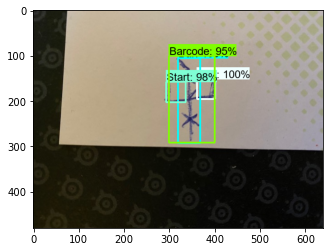

In [35]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """    
    return np.array(Image.open(path))

for image_path in IMAGE_PATHS:

    print('Running inference for {}... '.format(image_path), end='')

    image_np = load_image_into_numpy_array(image_path)

    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['num_detections'] = num_detections
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False,
          line_thickness=4)

    plt.imshow(image_np_with_detections)
    print('Done')
    plt.savefig("../../../Notebooks/result/{}.png".format(image_path.split("/")[-1].split(".")[0]), dpi=100)

In [59]:
category_index

{1: {'id': 1, 'name': 'Barcode'},
 2: {'id': 2, 'name': 'Bar'},
 3: {'id': 3, 'name': 'Start'},
 4: {'id': 4, 'name': 'End'}}

## Extract bars

In [67]:
def crop(image, coords):
    cropped_image = image.crop(coords)
    cropped_image.show()

In [225]:
from math import atan2, degrees

In [233]:
def get_ordered_bars(image, detection_scores, detection_classes, detection_boxes, threshold):
    idx = 0
    while detection_scores[idx] > threshold:
        idx += 1
        
    if idx < 2:
        return
        
    classes = detection_classes[:idx]
    boxes = detection_boxes[:idx] # box coordinates are (ymin, xmin, ymax, xmax)
    
    bar_boxes = [b for i, b in enumerate(boxes) if classes[i] == 2]
    if len(bar_boxes) < 1:
        return
    
    try:
        start_idx = classes.tolist().index(3)   
        end_idx = classes.tolist().index(4) # make sure it also has an end
        # exact center points not needed for sorting or angle => optimized by not dividing the sum
        start_center = (boxes[start_idx][3] + boxes[start_idx][1], boxes[start_idx][2] + boxes[start_idx][0])  
        end_center = (boxes[end_idx][3] + boxes[end_idx][1], boxes[end_idx][2] + boxes[end_idx][0])        
        angle = degrees(atan2(end_center[1] - start_center[1], end_center[0] - start_center[0]))
        
        bars = [(b_box[3] + b_box[1], b_box[2] + b_box[0], b_box) for b_box in bar_boxes]
        
        # exact distance no needed => optimized by not using sqrt when sorting
        bars.sort(key = lambda p: (p[0] - start_center[0])**2 + (p[1] - start_center[1])**2) 
        
        bar_images = []
        for bar in bars:
            cropped = image.crop((bar[2][1] * image.size[0],
                                  bar[2][0] * image.size[1],
                                  bar[2][3] * image.size[0],
                                  bar[2][2] * image.size[1]))
            rotated = cropped.rotate(angle, Image.NEAREST, expand = True) 
            
            bar_images.append(rotated)
            
        return bar_images
            
    except ValueError:
        return

In [228]:
def get_bars(image_path):
    expected_bars = image_path.split("/")[-1].split(".")[0].split("_")
    
    image_np = load_image_into_numpy_array(image_path)

    input_tensor = tf.convert_to_tensor(image_np)
    input_tensor = input_tensor[tf.newaxis, ...]

    detections = detect_fn(input_tensor)

    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                   for key, value in detections.items()}
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
    
    ordered_bars = get_ordered_bars(Image.open(image_path), 
                                    detections['detection_scores'], 
                                    detections['detection_classes'], 
                                    detections['detection_boxes'],
                                    0.4)
    
    if ordered_bars is None:
        return
    
    if len(ordered_bars) != len(expected_bars):
        return
    
    return list(zip(expected_bars, ordered_bars))

In [229]:
cleaned_image_folder = "../../../images_for_bars/"
image_paths = [cleaned_image_folder + f for f in listdir(cleaned_image_folder) if isfile(join(cleaned_image_folder, f))]

Extract the bars and save them in a separate folder for bar categorization training

In [234]:
idx = 0
for image_path in image_paths:
    print(image_path)
    bars = get_bars(image_path)
    if bars is None:
        continue
        
    for bar in bars:
        bar[1].save("../../../bars/{}_{}.png".format(bar[0], idx))
        
    idx += 1

../../../images_for_bars/1001967_284490.jpg
../../../images_for_bars/1002792_894582_934533_559328_389864.jpg
../../../images_for_bars/1002872_71578.jpg
../../../images_for_bars/1008962_921443_557114_627693_286167_126627.jpg
../../../images_for_bars/1016272_115580_763550_774581_655403.jpg
../../../images_for_bars/1019981.jpg
../../../images_for_bars/1023815.jpg
../../../images_for_bars/1026078_273053_301762.jpg
../../../images_for_bars/1028152_672883_284732_548158_763624.jpg
../../../images_for_bars/1035941.jpg
../../../images_for_bars/1038618_951710_665378_76047_82515_164047.jpg
../../../images_for_bars/126888.jpg
../../../images_for_bars/130414_692768_59603.jpg
../../../images_for_bars/131257_698073_794159.jpg
../../../images_for_bars/135472_149391.jpg
../../../images_for_bars/139281_549069_585633_49770.jpg
../../../images_for_bars/142139_419524_894859_812916.jpg
../../../images_for_bars/143779_124788_89206.jpg
../../../images_for_bars/147052_281278_97565_1035909_153584.jpg
../../../i